In [2]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [3]:
train_dir ='C:/Users/ANANNYA/Desktop/Data/Training'
test_dir = 'C:/Users/ANANNYA/Desktop/Data/Testing'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+"//" +label):
        train_paths.append(train_dir + '//'+label+ '//'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

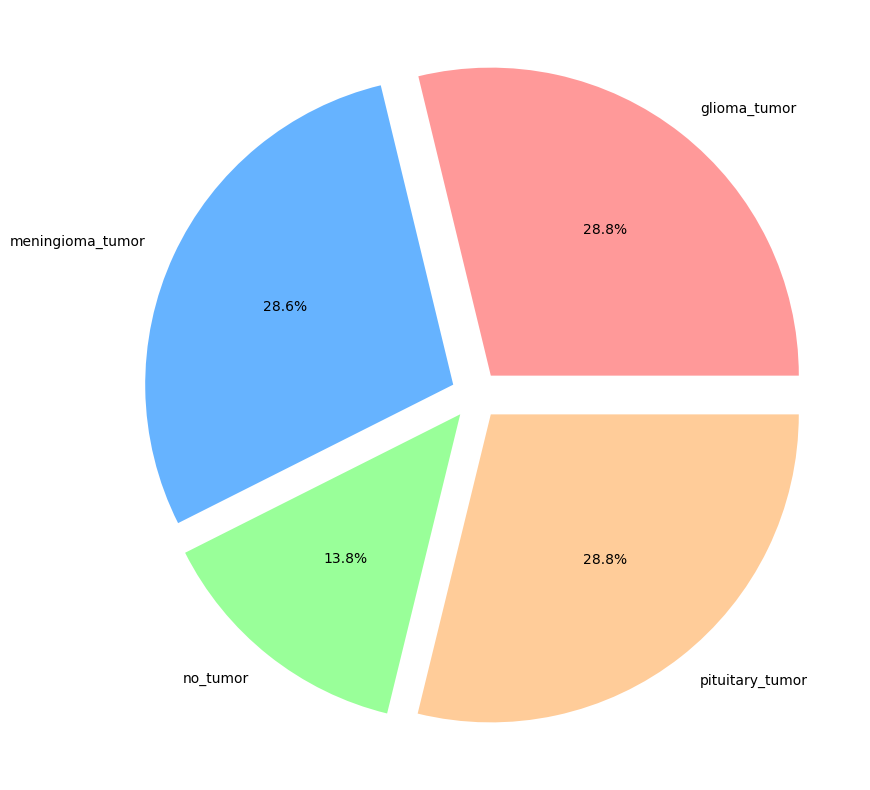

C:\Users\ANANNYA\f1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


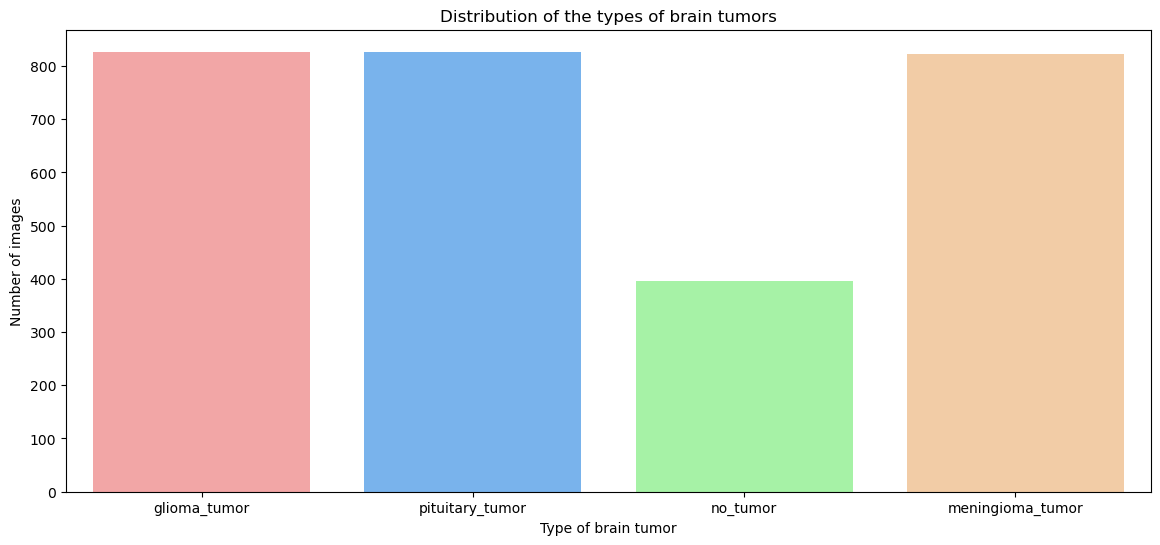

In [4]:
plt.figure(figsize=(10,10))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie([len(os.listdir(train_dir+"//" +label)) 
        for label in os.listdir(train_dir)],
         labels=os.listdir(train_dir),
          colors = colors,
           explode = (0.08,0.08,0.08,0.08) 
           ,autopct='%1.1f%%')
plt.show()




plt.figure(figsize=(14,6))
sns.countplot(train_labels, palette=colors)
plt.title('Distribution of the types of brain tumors')
plt.xlabel('Type of brain tumor')
plt.ylabel('Number of images');

In [5]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+ '//' + label):
        test_paths.append(test_dir +'//'+label + '//'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

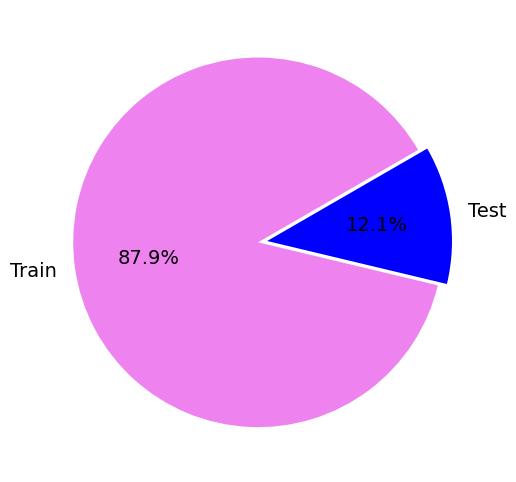

In [6]:
plt.figure(figsize=(14,6))
colors = ['Violet' , 'Blue']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [7]:
# Data Augmentation

In [8]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

In [9]:
#Example for the data:

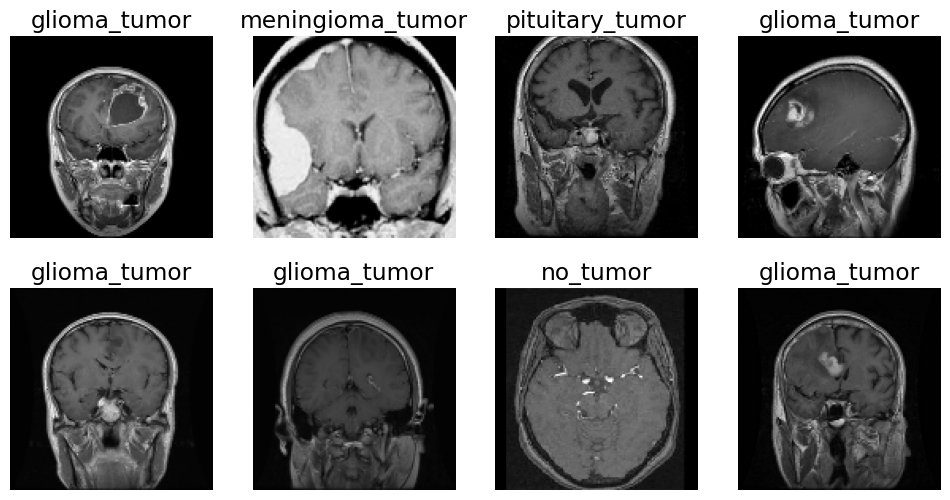

In [10]:
IMAGE_SIZE = 128


def open_images(paths):

    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)


images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [11]:
#Data Generator

In [12]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [13]:
#CNN Model

In [14]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 25088)             0

In [19]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [20]:
#Train CNN Model

In [21]:
model.fit(datagen(train_paths, train_labels, batch_size=32, epochs=10), steps_per_epoch=len(train_paths)//32, epochs=10)

Epoch 1/10
89/89 [==============================] - 30s 277ms/step - loss: 1.1330 - accuracy: 0.5284
Epoch 2/10
89/89 [==============================] - 23s 262ms/step - loss: 0.7169 - accuracy: 0.6906
Epoch 3/10
89/89 [==============================] - 23s 264ms/step - loss: 0.5109 - accuracy: 0.7977
Epoch 4/10
89/89 [==============================] - 23s 263ms/step - loss: 0.4029 - accuracy: 0.8457
Epoch 5/10
89/89 [==============================] - 23s 264ms/step - loss: 0.2939 - accuracy: 0.8851
Epoch 6/10
89/89 [==============================] - 24s 265ms/step - loss: 0.2741 - accuracy: 0.8971
Epoch 7/10
89/89 [==============================] - 23s 264ms/step - loss: 0.2285 - accuracy: 0.9133
Epoch 8/10
89/89 [==============================] - 24s 271ms/step - loss: 0.1473 - accuracy: 0.9496
Epoch 9/10
89/89 [==============================] - 25s 277ms/step - loss: 0.1199 - accuracy: 0.9612
Epoch 10/10
89/89 [==============================] - 25s 278ms/step - loss: 0.0720 - accura

In [22]:
#Evaluate the model

In [23]:
train_loss, train_acc = model.evaluate(open_images(train_paths), encode_label(train_labels))
test_loss, test_acc = model.evaluate(open_images(test_paths), encode_label(test_labels))

print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

13/13 [==============================] - 1s 57ms/step - loss: 5.7735 - accuracy: 0.7335
Train accuracy: 0.9717770218849182
Test accuracy: 0.7335025668144226


In [24]:
#VGG Model

In [25]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
N

In [27]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [28]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [29]:
#Train VGG Model

In [30]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 5
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
143/143 [==============================] - 212s 1s/step - loss: 0.7162 - sparse_categorical_accuracy: 0.7052
Epoch 2/5
143/143 [==============================] - 208s 1s/step - loss: 0.3533 - sparse_categorical_accuracy: 0.8670
Epoch 3/5
143/143 [==============================] - 212s 1s/step - loss: 0.2574 - sparse_categorical_accuracy: 0.8996
Epoch 4/5
143/143 [==============================] - 213s 1s/step - loss: 0.1980 - sparse_categorical_accuracy: 0.9309
Epoch 5/5
143/143 [==============================] - 212s 1s/step - loss: 0.1219 - sparse_categorical_accuracy: 0.9586


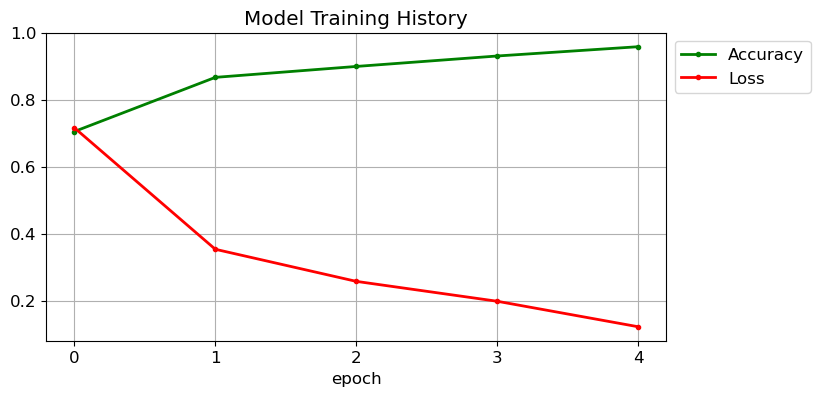

In [31]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [32]:
#Evaluate Model with Test Samples

In [33]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  8%|██████▉                                                                            | 1/12 [00:02<00:28,  2.57s/it]

1/1 [==============================] - 2s 2s/step


 17%|█████████████▊                                                                     | 2/12 [00:04<00:23,  2.32s/it]

1/1 [==============================] - 2s 2s/step


 25%|████████████████████▊                                                              | 3/12 [00:06<00:19,  2.19s/it]

1/1 [==============================] - 2s 2s/step


 33%|███████████████████████████▋                                                       | 4/12 [00:08<00:17,  2.16s/it]

1/1 [==============================] - 2s 2s/step


 42%|██████████████████████████████████▌                                                | 5/12 [00:11<00:15,  2.15s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [00:13<00:12,  2.14s/it]

1/1 [==============================] - 2s 2s/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:15<00:10,  2.19s/it]

1/1 [==============================] - 2s 2s/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [00:17<00:08,  2.18s/it]

1/1 [==============================] - 2s 2s/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:19<00:06,  2.13s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [00:21<00:04,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:23<00:02,  2.07s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:25<00:00,  2.05s/it]

1/1 [==============================] - 1s 822ms/step


13it [00:26,  2.04s/it]                                                                                                


In [34]:
print(classification_report(y_true, y_pred))

                  precision    recall  f1-score   support

    glioma_tumor       0.86      0.25      0.39       100
meningioma_tumor       0.69      0.98      0.81       115
        no_tumor       0.74      1.00      0.85       105
 pituitary_tumor       0.98      0.80      0.88        74

        accuracy                           0.77       394
       macro avg       0.82      0.76      0.73       394
    weighted avg       0.80      0.77      0.73       394



In [35]:
#Train Inception Model

In [36]:
# build inception model
base_model = InceptionV3(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True
base_model.layers[-5].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dropout_4 (Dropout)         (None, 256)              

In [37]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [38]:
model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])

batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 8
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/8
143/143 [==============================] - 47s 281ms/step - loss: 1.1714 - sparse_categorical_accuracy: 0.5140
Epoch 2/8
143/143 [==============================] - 38s 270ms/step - loss: 0.7939 - sparse_categorical_accuracy: 0.6818
Epoch 3/8
143/143 [==============================] - 39s 276ms/step - loss: 0.6779 - sparse_categorical_accuracy: 0.7330
Epoch 4/8
143/143 [==============================] - 38s 269ms/step - loss: 0.6025 - sparse_categorical_accuracy: 0.7551
Epoch 5/8
143/143 [==============================] - 37s 261ms/step - loss: 0.5456 - sparse_categorical_accuracy: 0.7775
Epoch 6/8
143/143 [==============================] - 37s 260ms/step - loss: 0.4912 - sparse_categorical_accuracy: 0.8109
Epoch 7/8
143/143 [==============================] - 40s 276ms/step - loss: 0.4607 - sparse_categorical_accuracy: 0.8274
Epoch 8/8
143/143 [==============================] - 39s 271ms/step - loss: 0.4051 - sparse_categorical_accuracy: 0.8488


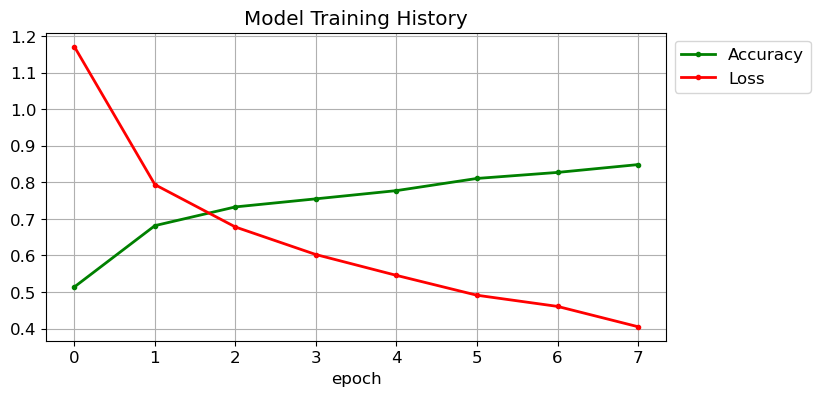

In [40]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [41]:
# Evaluate Model with Test Samples

In [42]:
# Evaluate model with test data
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  8%|██████▉                                                                            | 1/12 [00:02<00:29,  2.71s/it]

1/1 [==============================] - 0s 369ms/step


 17%|█████████████▊                                                                     | 2/12 [00:03<00:14,  1.42s/it]

1/1 [==============================] - 0s 371ms/step


 25%|████████████████████▊                                                              | 3/12 [00:03<00:09,  1.03s/it]

1/1 [==============================] - 0s 371ms/step


 33%|███████████████████████████▋                                                       | 4/12 [00:04<00:06,  1.20it/s]

1/1 [==============================] - 0s 326ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [00:04<00:04,  1.40it/s]

1/1 [==============================] - 0s 323ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [00:05<00:03,  1.60it/s]

1/1 [==============================] - 0s 329ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:05<00:02,  1.75it/s]

1/1 [==============================] - 0s 374ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [00:06<00:02,  1.80it/s]

1/1 [==============================] - 0s 359ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:06<00:01,  1.83it/s]

1/1 [==============================] - 0s 330ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [00:07<00:01,  1.90it/s]

1/1 [==============================] - 0s 366ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:07<00:00,  1.90it/s]

1/1 [==============================] - 0s 329ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.97it/s]

1/1 [==============================] - 2s 2s/step


13it [00:10,  1.27it/s]                                                                                                


In [43]:
print(classification_report(y_true, y_pred))

                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.29      0.45       100
meningioma_tumor       0.59      0.84      0.69       115
        no_tumor       0.60      0.90      0.72       105
 pituitary_tumor       0.88      0.47      0.61        74

        accuracy                           0.65       394
       macro avg       0.76      0.63      0.62       394
    weighted avg       0.74      0.65      0.62       394

